In [2]:
import nibabel as nib
from nibabel.processing import resample_to_output
import numpy as np
import pandas as pd
from glob import glob
import re
import matplotlib.pyplot as plt

# Import libraries for keras
# # set the matplotlib backend so figures can be saved in the background
# import matplotlib
# matplotlib.use("Agg")
import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=cuda0,floatX=float32"
os.environ["KERAS_BACKEND"] = "theano"
import theano
import keras

# import the necessary packages
# from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers.core import Dense
# from keras.optimizers import SGD
# from imutils import paths
# import argparse
import random
# import pickle
# import cv2
import os
import os.path

Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
/Users/mcrichter/anaconda3/envs/theano_py27/bin/../lib/gcc/x86_64-conda_cos6-linux-gnu/7.3.0/../../../../x86_64-conda_cos6-linux-gnu/bin/ld: cannot find -lcudnn
collect2: error: ld returned 1 exit status

Mapped name None to device cuda0: Tesla P100-PCIE-16GB (0000:81:00.0)
Using Theano backend.


In [3]:
'''
    Checks whether a file exists and converts to local or cluster path if necessary
'''
def check_file_path(file_path):
    if os.path.isfile(file_path):
        return file_path
    else:
        to_cluster_path = "/Dedicated/jmichaelson-" + file_path[1:]
        to_local_path = "/" + file_path[22:]

        if os.path.isfile(to_cluster_path):
            return to_cluster_path
        elif os.path.isfile(to_local_path):
            return to_local_path
        else:
            print("No valid file path")
            return "NOPE"

## The labels

In [9]:
# zero-pad some of the entries so they match the filenames
label_file = '/wdata/mcrichter/HackUiowa2018/DATA/2018_IA_Hackathon/Factor_Data/comprehension_ability_crystalized_intelligence_with_the_variance_of_g_removed.xlsx'
df = pd.read_excel(check_file_path(label_file),
                   converters={'ID': lambda x: str(x).zfill(4)},
          )
# make the ID the index in the pandas dataframe
df.set_index('ID', inplace=True)
df.head()

,Score
ID,
0194,0.280165
0297,0.390203
0318,0.555099
0376,-0.412211
0414,-1.209015


## The data

In [ ]:
# Get all lesion masks
data_collector = {}
img_collector = {}
lesion_masks = glob('/wdata/mcrichter/HackUiowa2018/DATA/2018_IA_Hackathon/Factor_Data/All_subs_405_Lesion_Masks/*.nii.gz')
for les_file in lesion_masks:
    match = re.match(r'.*/([0-9]{4}).nii.gz', les_file)
    sub_id = match.groups()[0]
    les_img = nib.load(les_file)
    img_collector[sub_id] = les_img
    les_img_resamp = resample_to_output(les_img, voxel_sizes=(3, 3, 3))
    les_data = les_img_resamp.get_data()
    les_data_1d = les_data.reshape(np.prod(les_data.shape))
    data_collector[sub_id] = les_data_1d

In [ ]:
group_df = pd.DataFrame.from_dict(data_collector, orient='index')

In [ ]:
total_df = group_df.join(df).sort_index()

In [ ]:
# remove columns with only 0
reduced_group_df = group_df.loc[:, (group_df != 0).any(axis=0)]
# add intercept column
reduced_group_df.loc[:,'intercept'] = [1] * len(reduced_group_df)
reduced_group_df['intercept']
len(reduced_group_df.columns)

In [ ]:
#Combine data frames
total_data_df = reduced_group_df.join(df).sort_index()

In [10]:
print("Load data...")
total_data_df_path = '/Dedicated/jmichaelson-wdata/mcrichter/HackUiowa2018/NN_behaviour/total_data_df_reduced_no_0_columns.csv'
total_data_df = pd.read_csv(check_file_path(total_data_df_path))
total_data_df.rename(columns={'Unnamed: 0': 'ID'}, inplace=True)
total_data_df.set_index('ID', inplace=True)

Load data...


Create model...
Compile model...
Fit model...
Train on 364 samples, validate on 41 samples
Epoch 1/20
364/364 [==============================] - 0s 1ms/step - loss: 0.0343 - mean_absolute_error: 0.1486 - val_loss: 0.0300 - val_mean_absolute_error: 0.1381
Epoch 2/20
364/364 [==============================] - 0s 1ms/step - loss: 0.0335 - mean_absolute_error: 0.1465 - val_loss: 0.0298 - val_mean_absolute_error: 0.1385
Epoch 3/20
364/364 [==============================] - 0s 1ms/step - loss: 0.0334 - mean_absolute_error: 0.1464 - val_loss: 0.0297 - val_mean_absolute_error: 0.1389
Epoch 4/20
364/364 [==============================] - 0s 1ms/step - loss: 0.0334 - mean_absolute_error: 0.1462 - val_loss: 0.0295 - val_mean_absolute_error: 0.1400
Epoch 5/20
364/364 [==============================] - 0s 1ms/step - loss: 0.0333 - mean_absolute_error: 0.1461 - val_loss: 0.0295 - val_mean_absolute_error: 0.1411
Epoch 6/20
364/364 [==============================] - 0s 1ms/step - loss: 0.0333 - mean_a

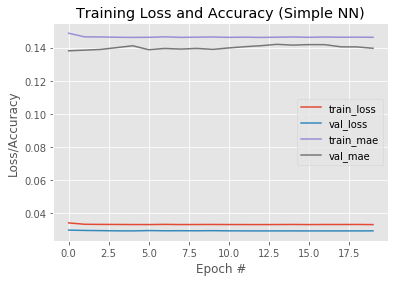

In [11]:
seed = 42
total_data_df_shuffled = shuffle(total_data_df, random_state=seed)


X = total_data_df_shuffled.drop(["intercept", "Score"], axis = 1)
y = total_data_df_shuffled[["Score"]]

# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler()

# Create an object to transform the data to fit minmax processor
y_scaled = min_max_scaler.fit_transform(y)

# Run the normalizer on the dataframe
y_normalized = pd.DataFrame(y_scaled, columns = ['Score_normalized'])

(trainX, testX, trainY, testY) = train_test_split(X, y_normalized, test_size=0.1, random_state=seed)


# import tensorflow as tf
# from keras.backend.tensorflow_backend import set_session
# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.9
# set_session(tf.Session(config=config))

print("Create model...")
model = Sequential()
model.add(Dense(10000, input_shape=(trainX.shape[1],), activation="sigmoid"))
model.add(Dense(5000, activation="sigmoid"))
model.add(Dense(500, activation="sigmoid"))
model.add(Dense(50, activation="sigmoid"))
model.add(Dense(1, activation="sigmoid"))


# initialize our initial learning rate and # of epochs to train for
INIT_LR = 0.01
EPOCHS = 20
BATCH_SIZE = 30

# compile the model
print("Compile model...")
model.compile(loss='mean_squared_error', optimizer="SGD", metrics=["mae"])

print("Fit model...")
H = model.fit(trainX, trainY, validation_data=(testX, testY), epochs=EPOCHS, batch_size=BATCH_SIZE)
print("Done")

########### PLOT ######################

# evaluate the network
# print("[INFO] evaluating network...")
# predictions = model.predict(testX, batch_size=BATCH_SIZE)
# print(classification_report(testY.argmax(axis=1),
# predictions.argmax(axis=1), target_names=lb.classes_))

# plot the training loss and accuracy
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["mean_absolute_error"], label="train_mae")
plt.plot(N, H.history["val_mean_absolute_error"], label="val_mae")
plt.title("Training Loss and Accuracy (Simple NN)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
# plt.savefig(args["plot"])